## Notebook to visualize cell-type importance based on colocalziation between PD risk and cell-specific eQTL

modified off the colocalization heatmap notebook

In [1]:
!date

Fri Feb 10 20:56:44 UTC 2023


#### import libraries

In [2]:
from pandas import read_csv, concat, read_parquet, DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from seaborn import barplot, color_palette
from os.path import exists

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming
cohort = 'foundin'
dx = 'PD'
day = 'daNA'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
results_dir = f'{wrk_dir}/results'
public_dir = f'{wrk_dir}/public'

# out files
index_variants_file = f'{public_dir}/nalls_pd_gwas/index_variants.list' 

# variables
DEBUG = False
modalities = ['Bryois-Astro', 'Bryois-Endo', 'Bryois-ExN', 'Bryois-InN', 
              'Bryois-Micro', 'Bryois-OPC', 'Bryois-Oligo', 'Bryois-Peri', 
              'DAn-meta', 'Bulk-meta']
dpi_value = 100
min_h4 = 0.2

### for each day and modality load the colocalization results

In [4]:
coloc_df = None
for modality in modalities:
    print(day, modality, end=':')
    in_file = f'{results_dir}/{cohort}_{day}_{modality}_{dx}.coloc.pp.csv'
    if exists(in_file):
        this_df = read_csv(in_file)
        print(f'loaded {this_df.shape[0]} results')
        # add day and modality
        this_df['day'] = day
        this_df['modality'] = modality
        coloc_df = concat([coloc_df, this_df])
print(f'\ntotal results loaded {coloc_df.shape[0]}')
if DEBUG:
    display(coloc_df.sample(5))
    display(coloc_df.day.value_counts())
    display(coloc_df.modality.value_counts()) 

daNA Bryois-Astro:loaded 31 results
daNA Bryois-Endo:loaded 19 results
daNA Bryois-ExN:loaded 56 results
daNA Bryois-InN:loaded 41 results
daNA Bryois-Micro:loaded 28 results
daNA Bryois-OPC:loaded 22 results
daNA Bryois-Oligo:loaded 37 results
daNA Bryois-Peri:loaded 18 results
daNA DAn-meta:loaded 35 results
daNA Bulk-meta:loaded 40 results

total results loaded 327


### subset based on the minimum H4 variable

In [5]:
temp = coloc_df.loc[coloc_df.H4 > min_h4]
print(f'{temp.feature.nunique()} traits will be used')
coloc_df = coloc_df.loc[coloc_df.feature.isin(temp.feature)]
print(f'results shape after filter on H4 {coloc_df.shape}')
if DEBUG:
    display(coloc_df.head())
    display(coloc_df.modality.value_counts()) 

137 traits will be used
results shape after filter on H4 (270, 9)


### sum H4 probabilities by modality
since here just using single day = daNA don't have to worry about multiple days

In [6]:
def sum_h4s(df: DataFrame, weighted: bool=False, verbose: bool=False) -> DataFrame:
    if weighted:
        cell_type_sums = df.groupby(by='modality').agg({'weighted_h4': 'sum'})
        append_str = 'weighted'
    else:
        cell_type_sums = df.groupby(by='modality').agg({'H4': 'sum'})
        append_str = ''
    print(f'shape of cell-type {append_str} H4 sums is {cell_type_sums.shape}')
    cell_type_sums['cell-type'] = cell_type_sums.index
    if DEBUG:
        display(cell_type_sums)
    return cell_type_sums

def plot_importance(sums_df: DataFrame, weighted: bool=False):
    if weighted:
        key = 'weighted_h4'
        key_label = 'weighted H4'
    else:
        key_label = key = 'H4'
    temp = sums_df.sort_values(key, ascending=False)
    with rc_context({'figure.figsize': (9, 9), 'figure.dpi': 50}):
        plt.style.use('seaborn-bright')    
        barplot(data=temp, x=key, y='cell-type', palette='Purples_r')    
        plt.title('Cell-type importance based on risk and eQTL colocalization')
        plt.xlabel(f'Sum of {key_label}')
        plt.ylabel('Cell Type')
        plt.show()

In [7]:
cell_type_sums = sum_h4s(coloc_df, verbose=DEBUG)

shape of cell-type  H4 sums is (10, 1)


### visualize to cell importance based on cell-type H4 sum

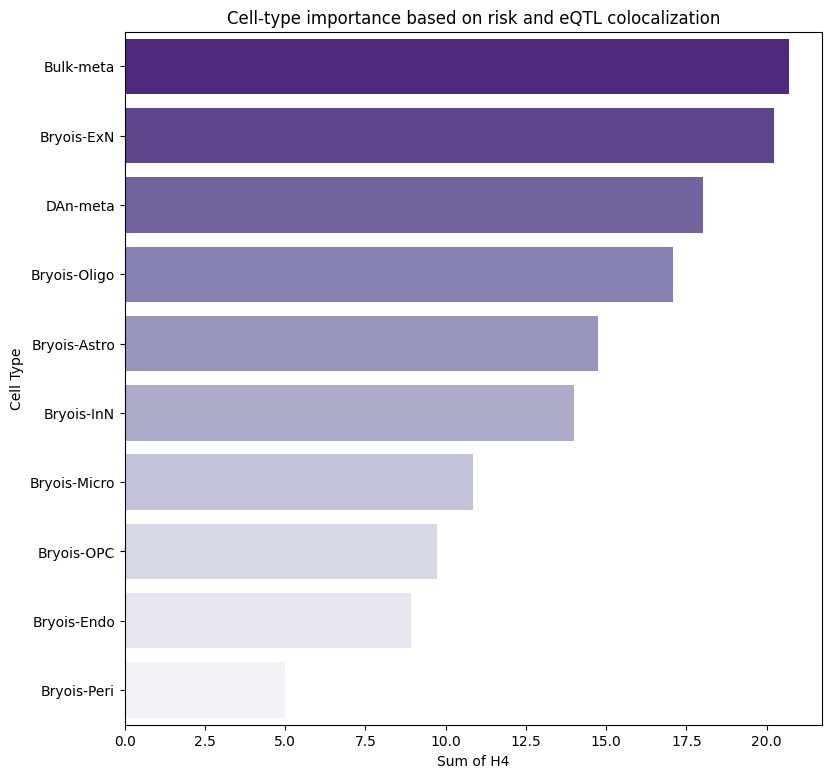

In [8]:
plot_importance(cell_type_sums)

### weight colocalizations by risk effect

#### load the risk variants of interest

In [9]:
%%time
index_vars_df = read_csv(index_variants_file)
print(index_vars_df.shape)
index_variants = list(index_vars_df.variant.unique())
if DEBUG:
    display(index_vars_df.head())
    print(index_variants)

(91, 1)
CPU times: user 117 µs, sys: 4.13 ms, total: 4.25 ms
Wall time: 2.98 ms


#### load variant colocalization info

In [10]:
causals_df = None
for modality in modalities:
    print(day, modality, end=':')
    in_file = f'{results_dir}/{cohort}_{day}_{modality}_{dx}.casuals.pp.parquet'
    if exists(in_file):
        this_df = read_parquet(in_file)
        print(f'loaded {this_df.shape[0]} results')
        if 'MarkerName' in this_df.columns:
            this_df['feature'] = this_df.MarkerName.str.split(':', expand=True)[0]
        else:
            this_df = this_df.rename(columns={'phenotype_id': 'feature'})
        # add day and modality
        this_df['day'] = day
        this_df['modality'] = modality
        keep_cols = ['beta', 'logABF_risk', 'PP_risk',
                     'logABF_qtl',  'PP_qtl',
                     'h4_pp', 'feature', 'day', 'modality']        
        # subset to consistent cols prior to concat
        this_df = this_df[keep_cols]
        causals_df = concat([causals_df, this_df])
print(f'\ntotal results loaded {causals_df.shape[0]}')
# subset to just the results that intersect with risk indices
causals_df = causals_df.loc[causals_df.index.isin(index_variants)]
print(f'\risk index results loaded {causals_df.shape[0]}')
if DEBUG:
    display(causals_df.sample(5))
    display(causals_df.day.value_counts())
    display(causals_df.modality.value_counts()) 

daNA Bryois-Astro:loaded 69199 results
daNA Bryois-Endo:loaded 36462 results
daNA Bryois-ExN:loaded 118119 results
daNA Bryois-InN:loaded 84809 results
daNA Bryois-Micro:loaded 65845 results
daNA Bryois-OPC:loaded 53576 results
daNA Bryois-Oligo:loaded 79213 results
daNA Bryois-Peri:loaded 34881 results
daNA DAn-meta:loaded 47593 results
daNA Bulk-meta:loaded 48865 results

total results loaded 638562
isk index results loaded 318


#### merge the coloc H4 with the causals H4_PP

In [11]:
causals_df['variant'] = causals_df.index
combine_df = coloc_df.merge(causals_df, how='inner', on=['feature', 'modality'], 
                            suffixes=['_coloc', '_causals'])
print(f'combined shape is {combine_df.shape}')
if DEBUG:
    display(combine_df.sample(5))

combined shape is (318, 17)


#### compute the weighted value

In [12]:
combine_df['weighted_h4'] = combine_df.H4 * combine_df.beta.abs()
# combine_df['weighted_h4'] = combine_df.H4 * combine_df.logABF_risk
print(f'modified combined shape is {combine_df.shape}')
if DEBUG:
    display(combine_df.sample(5))

modified combined shape is (318, 18)


### visualize to cell importance based on cell-type H4 sum

shape of cell-type weighted H4 sums is (10, 1)


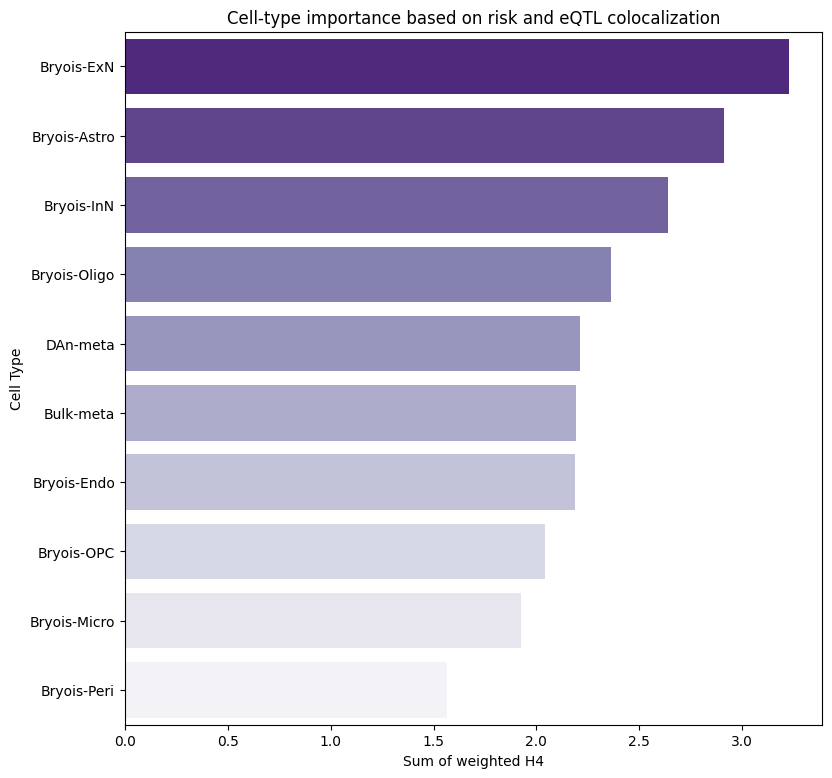

In [13]:
cell_type_sums = sum_h4s(combine_df, weighted=True, verbose=DEBUG)
plot_importance(cell_type_sums, weighted=True)

### assign feature to cell based on best H4 value

In [14]:
coloc_best_df = coloc_df.sort_values(by='H4', ascending=False).drop_duplicates(['feature'], keep='first')
print(f'shape of coloc tops {coloc_best_df.shape}')
if DEBUG:
    display(coloc_best_df.sample(5))

shape of coloc tops (137, 9)


In [15]:
feature = 'CCAR2'
display(coloc_best_df.loc[coloc_best_df.feature == feature])
display(coloc_df.loc[coloc_df.feature == feature])

,H0,H1,H2,H3,H4,feature,h4_supported,day,modality
37,0.0,0.0,0.0,0.021,0.979,CCAR2,True,daNA,Bulk-meta


,H0,H1,H2,H3,H4,feature,h4_supported,day,modality
29,0.000,0.152,0.0,0.133,0.714,CCAR2,True,daNA,Bryois-Astro
17,0.001,0.189,0.0,0.137,0.673,CCAR2,True,daNA,Bryois-Endo
50,0.000,0.000,0.0,0.029,0.971,CCAR2,True,daNA,Bryois-ExN
37,0.000,0.115,0.0,0.097,0.788,CCAR2,True,daNA,Bryois-InN
32,0.000,0.000,0.0,0.037,0.962,CCAR2,True,daNA,DAn-meta
37,0.000,0.000,0.0,0.021,0.979,CCAR2,True,daNA,Bulk-meta


### visualize to cell importance based on cell-type H4 sum

shape of cell-type  H4 sums is (10, 1)


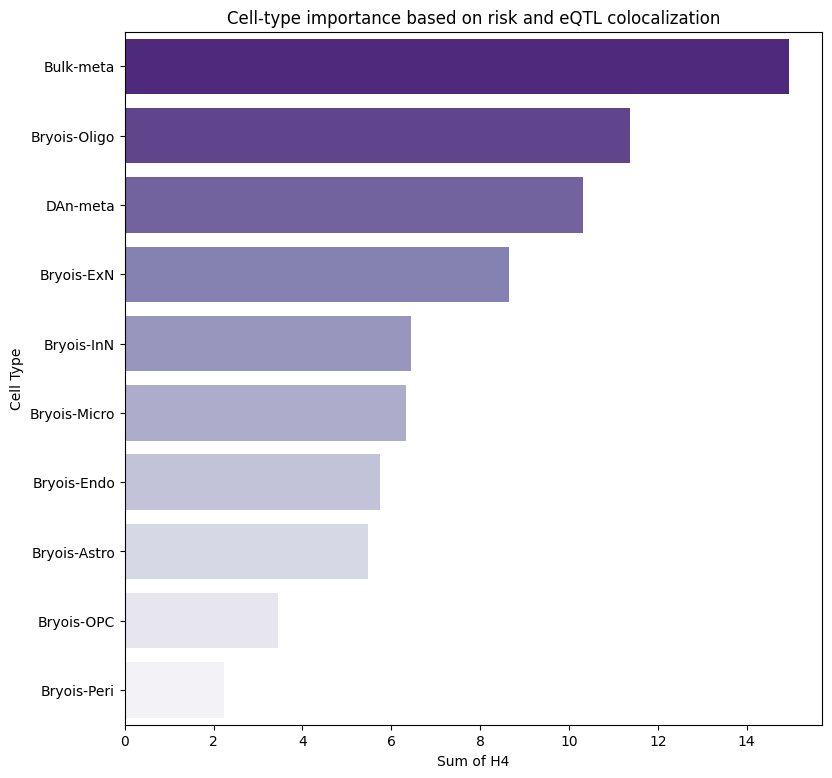

In [16]:
cell_type_sums = sum_h4s(coloc_best_df, verbose=DEBUG)
plot_importance(cell_type_sums)

In [17]:
!date

Fri Feb 10 20:56:46 UTC 2023
